In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon
import geopandas as gpd

## Finding a map

To be able to visualize the original Chernobyl data, I needed to find a map to place the data points on. 
I found this map (1 cm is 500 km) on Natural Earth's website. 

In [2]:
from ChernobylUtility import UsefulFunctions as uf

In [3]:
shapefile = 'ne_50m_admin_0_countries.shp'
gdf_world = uf.read_world_map(shapefile)

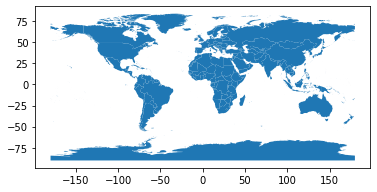

In [4]:
gdf_world.plot()

## Matching up those countries

Now that I had a map, I needed to isolate the parts of the map related to the Chernobyl dataset. In other words, I needed to find the countries in Chernobyl and use them to select the right countries on the map. 

In [5]:
## TODO modify setting functions to completely reset every erroneous part of the dataset
## TODO consider renaming the map of europe to something else since it initially contains australia

In [6]:
air = pd.read_csv('processed_chernair.csv')

We get the countries in our air dataset and see which ones may not be present in the world. 

In [7]:
uf.check_countries(air, gdf_world)

{'F', 'UK', 'NO'}


False

This tells us that F, NO, and UK are within the Chernobyl dataset, but they aren't within the map dataset. 
Intuitively, we think F is just France, NO is Norway, and UK is the United Kingdom, but we need to be sure. 

In [8]:
air.loc[air['country_code'] == 'F'].head(1)

Unnamed: 0 country_code  Code       city  latitude  longitude  \
277         277            F     3  CADARACHE      5.75      43.71   

           Date  endsampling  duration  i131   cs134  cs137  
277  1986-05-01            9      24.0   0.3  0.0008   0.02

A quick online search confirms that Cadarache is indeed a city in France. Also the lat long coordinates confirm this. 

The discrepancy with 'UK' can be explained by looking at the world map. It contains GB instead of UK for the country code of the United Kingdom. 

In [9]:
gdf_world.loc[gdf_world.country_code == 'GB']

country country_code  \
31  United Kingdom           GB   

                                             geometry  
31  MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...

So, we change France and United Kingdom to have country codes of FR and GB respectively.

In [10]:
uf.set_france_uk(air)

Now, I look up France and Norway in the map datset. 

In [11]:
gdf_world[gdf_world.country == 'Norway']

country country_code                                           geometry
88  Norway          -99  MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...

In [12]:
gdf_world[gdf_world.country == 'France']

country country_code                                           geometry
160  France          -99  MULTIPOLYGON (((9.48037 42.80542, 9.45420 42.6...

Both of these have -99 for their country codes so we fix that. 

In [13]:
uf.set_norway_france(gdf_world) 

Now, we recheck that our countries match up. 

In [14]:
uf.check_countries(air, gdf_world)

True

To recap, we found the countries represented in the Chernobyl dataset, and found these same countries in the world map dataset. 
Then, we made sure their country codes matched up. 

## Plotting the right countries
Now, we plot the countries from the Chernobyl dataset. Although the Chernobyl dataset does not contain Ukraine, we will include Ukraine since this is where the accident happened. 

In [15]:
gdf_europe = uf.make_europe_map(air, gdf_world)

In [16]:
gdf_europe.plot()

The plot seems to be stretched out given that Australia and Atlantic Ocean islands are on it. After plotting data, we'll be able to see which parts of the map we can eliminate to allow for better resolution. 

I suspect our map qualifies all territories belonging to a country as that country. For example, plotting France doesn't just plot continental europe France, but the island territories. 

## Placing the data on the map
Now that we have a background map, we can try placing the concentration data on the map. Doing so merely requires changing our original dataset into a Geopandas Data Frame. 

In [17]:
gdf_air = uf.make_gdf_air(air)

We can try to plot the data onto the map we made. 

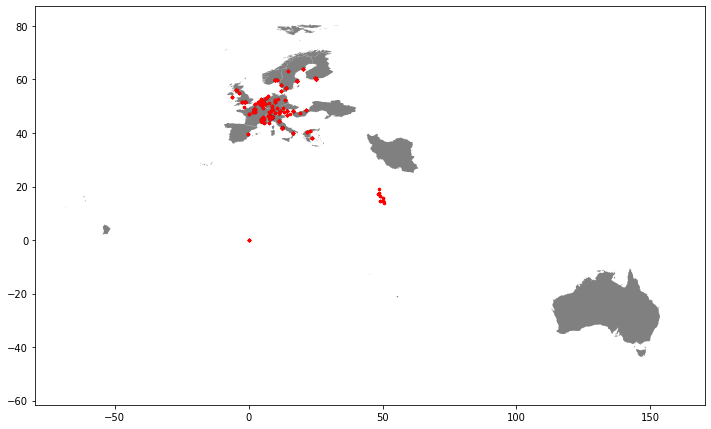

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 5, color = 'r', alpha = 0.5)

Most of our markers fall where we'd expect them to (in Europe). Note, however, the pile of dots near (50, 20) and the solitary dot at (0,0). It's unlikely coordinates were taken in the ocean so we need to find out why these are plotted this way. 

## Low point management 

In this section, we determine how to work with the low points we saw in the plot above. 

### Acquiring the low points

In this section we select the low points. This selections is based on looking at the plot, and observing low points exist below twenty two degrees latitude. 

In [19]:
index_list = uf.find_low_points(gdf_air)

In [20]:
low_points = gdf_air.iloc[index_list]

We plot to check our low points. 

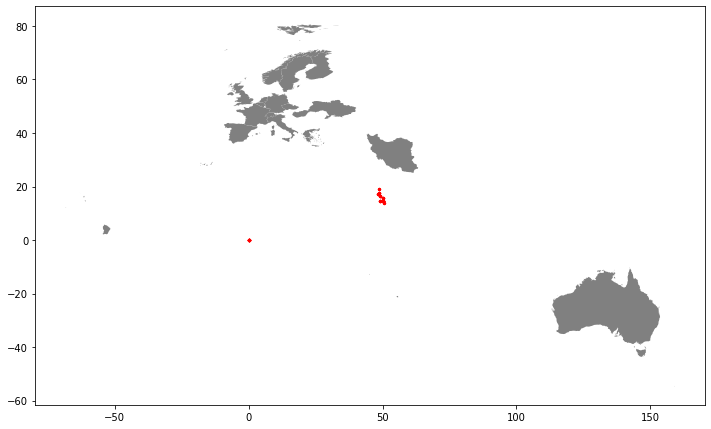

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
low_points.plot(ax = ax, markersize = 5, color = 'r', alpha = 0.5)

We can see we did indeed select the right points from the map. Now we try to find where we should place these points. 

### Finding the right places for the points 

Now we will determine where these low points hould be placed. To do this, we will look at their country code. 

In [22]:
low_points['country_code'].groupby([low_points['city']]).describe()

count unique top freq
city                            
BANSKA         6      1  CZ    6
BRATISLAVA    10      1  CZ   10
CESKE         12      1  CZ   12
HRADEC        11      1  CZ   11
JASLOVSKE     11      1  CZ   11
MORAVSKY      13      1  CZ   13
PRAHA         39      1  CZ   39
USTI           5      1  CZ    5
VAERNES        8      1  NO    8
VALENCIA      26      1  ES   26

We have three different countries represented, each of which is usually considered to be in continental Europe - Czechia, Norway, and Spain. 

### Checking readings for original dataset and low points set

Is it safe to assume that all CZ entries were low points in the original air data? Similarly, is all data for Vaernes, NO and Valencia, ES off in the original dataset?

In [23]:
gdf_air['country_code'].groupby([gdf_air['city'] == 'VAERNES']).describe()

count unique top freq
city                       
False  2043     16  IT  303
True      8      1  NO    8

There are 8 counts for Vaernes in low points as well so when we find out the issue, we will replace all Vaernes data in the original set. 

In [24]:
gdf_air['country_code'].groupby([gdf_air['city'] == 'VALENCIA']).describe()

count unique top freq
city                       
False  2025     16  IT  303
True     26      1  ES   26

We also see 26 counts for Valencia in low points so we will be replacing all Valencia data in the original set. 

Since CZ had multiple cities, we take a look at a group of CZ data for original air and low point data. 

In [25]:
gdf_air['city'].groupby([gdf_air['country_code'] == 'CZ']).count()

country_code
False    1917
True      134
Name: city, dtype: int64

In [26]:
low_points['city'].groupby([low_points['country_code'] == 'CZ']).count()

country_code
False     34
True     107
Name: city, dtype: int64

Note that there are 134 measurements taken from CZ in gdf_air (original air data), and 107 measurements in the low points. 
This suggests that there are CZ measurements in the original data not present in the low points. So, we will be careful to only modify low point measurements in the original dataset. 

### Valencia and Vaernes

Most of our low points should be in CZ, but two points should be in NO and ES. Recall these are codes for Spain and Norway. An internet search reveals that Vaernes and Valencia should both be in continental europe. But, for some reason they both had (0,0) coordinates (see below). So, that singular point at (0,0) actually masked two difference city measurements.  

In [27]:
low_points.loc[low_points['city'] == 'VAERNES'].longitude.sum()

0.0

In [28]:
low_points.loc[low_points['city'] == 'VAERNES'].latitude.sum()

0.0

Note that any result other than zero would indicate at least one measurement was not at (0,0). This also holds for Valencia data below. 

In [29]:
low_points.loc[low_points['city'] == 'VALENCIA'].longitude.sum()

0.0

In [30]:
low_points.loc[low_points['city'] == 'VALENCIA'].latitude.sum()

0.0

A simple online search gives us the lat long coordinates for each city. We give these cities the appropriate lat and long measures. 

In [31]:
gdf_air = uf.modify_vaernes_valencia(gdf_air)

In [32]:
gdf_air.loc[gdf_air.city == 'VAERNES'].head()

Unnamed: 0 country_code  Code     city  latitude  longitude        Date  \
1716        1716           NO    21  VAERNES  10.32774   59.19986  1986-04-28   
1717        1717           NO    21  VAERNES  10.32774   59.19986  1986-04-29   
1718        1718           NO    21  VAERNES  10.32774   59.19986  1986-04-30   
1719        1719           NO    21  VAERNES  10.32774   59.19986  1986-05-02   
1720        1720           NO    21  VAERNES  10.32774   59.19986  1986-05-05   

      endsampling  duration  i131  cs134   cs137                   geometry  
1716           18       9.0  7.00    0.0  2.0000  POINT (10.32774 59.19986)  
1717            9      15.0  9.00    0.0  3.0000  POINT (10.32774 59.19986)  
1718            9      24.0  5.00    0.0  2.0000  POINT (10.32774 59.19986)  
1719            9      48.0  0.30    0.0  0.1100  POINT (10.32774 59.19986)  
1720            9      72.0  0.08    0.0  0.0011  POINT (10.32774 59.19986)

In [33]:
gdf_air.loc[gdf_air.city == 'VALENCIA'].head()

Unnamed: 0 country_code  Code      city  latitude  longitude  \
1253        1253           ES    11  VALENCIA -0.376288  39.469906   
1254        1254           ES    11  VALENCIA -0.376288  39.469906   
1255        1255           ES    11  VALENCIA -0.376288  39.469906   
1256        1256           ES    11  VALENCIA -0.376288  39.469906   
1257        1257           ES    11  VALENCIA -0.376288  39.469906   

            Date  endsampling  duration  i131   cs134   cs137  \
1253  1986-05-01            0      24.0   0.0  0.0000  0.0470   
1254  1986-05-02            0      24.0   0.0  0.0054  0.0351   
1255  1986-05-03            0      24.0   0.0  0.0410  0.0995   
1256  1986-05-04            0      24.0   0.0  0.0000  0.1082   
1257  1986-05-05            0      24.0   0.0  0.0000     NaN   

                       geometry  
1253  POINT (-0.37629 39.46991)  
1254  POINT (-0.37629 39.46991)  
1255  POINT (-0.37629 39.46991)  
1256  POINT (-0.37629 39.46991)  
1257  POINT (-0.37629 39.46991)

We note our original geo data frame changed to accomodate new coordinates. 

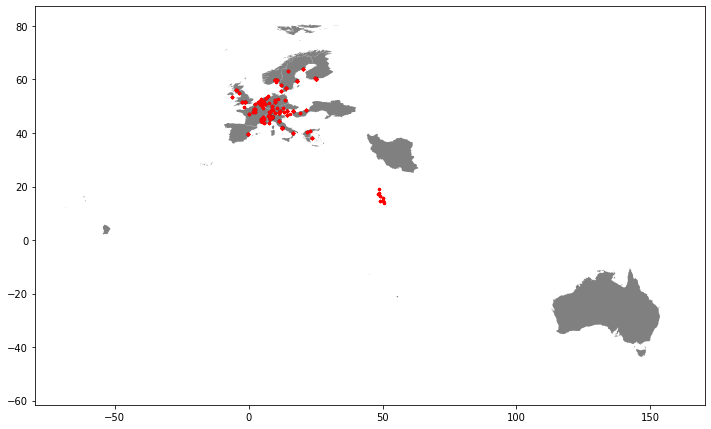

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 5, color = 'r', alpha = 0.5)

Note the (0,0) points are now in continental Europe. 

### Czechia points

Now consider the CZ points. 

In [35]:
low_points.loc[low_points.country_code == 'CZ']

Unnamed: 0 country_code  Code    city  latitude  longitude        Date  \
1904        1904           CZ    23  BANSKA     48.73      19.17  1986-05-01   
1905        1905           CZ    23  BANSKA     48.73      19.17  1986-05-02   
1906        1906           CZ    23  BANSKA     48.73      19.17  1986-05-03   
1907        1907           CZ    23  BANSKA     48.73      19.17  1986-05-05   
1908        1908           CZ    23  BANSKA     48.73      19.17  1986-05-06   
...          ...          ...   ...     ...       ...        ...         ...   
2033        2033           CZ    23    USTI     50.68      14.00  1986-05-01   
2034        2034           CZ    23    USTI     50.68      14.00  1986-05-02   
2035        2035           CZ    23    USTI     50.68      14.00  1986-05-03   
2036        2036           CZ    23    USTI     50.68      14.00  1986-05-04   
2037        2037           CZ    23    USTI     50.68      14.00  1986-05-05   

      endsampling  duration   i131  cs134  cs137                   geometry  
1904            5      24.0  3.150  0.000    NaN  POINT (48.73000 19.17000)  
1905            5      24.0  1.240  0.050    NaN  POINT (48.73000 19.17000)  
1906            5      24.0  0.763  0.000    NaN  POINT (48.73000 19.17000)  
1907            5      24.0  0.367  0.000    NaN  POINT (48.73000 19.17000)  
1908            5      24.0  0.535  0.000    NaN  POINT (48.73000 19.17000)  
...           ...       ...    ...    ...    ...                        ...  
2033            5      24.0  5.240  1.400    NaN  POINT (50.68000 14.00000)  
2034            5      24.0  4.810  1.430    NaN  POINT (50.68000 14.00000)  
2035            5      24.0  0.196  0.013    NaN  POINT (50.68000 14.00000)  
2036            5      24.0  1.300  0.502    NaN  POINT (50.68000 14.00000)  
2037            5      24.0  1.320  0.560    NaN  POINT (50.68000 14.00000)  

[107 rows x 13 columns]

You'll note these already have long and lats. An internet search reveals that Banska should have long 19.17 and lat 48.73 instead of what's in the data. In other words, the lat and long got switched! It may be the case that all lat and long measures for CZ were switched in the original dataset. We check that before proceeding. 

To do this, let's find a reasonable range of lattitudes and longs for CZ. 

In [36]:
gdf_europe.loc[gdf_europe.country_code == 'CZ'].plot()

This suggests that longs will be between 12 and 19, while lats wll be between 48.5 and 51. So, we can look for entries in lats and see if they fall within the range 12 to 19. If not, we select them and switch their lats and longs. 

In [37]:
out_indices = uf.find_swapped_cz(gdf_air)

In [38]:
uf.swap_lat_long(gdf_air, out_indices)

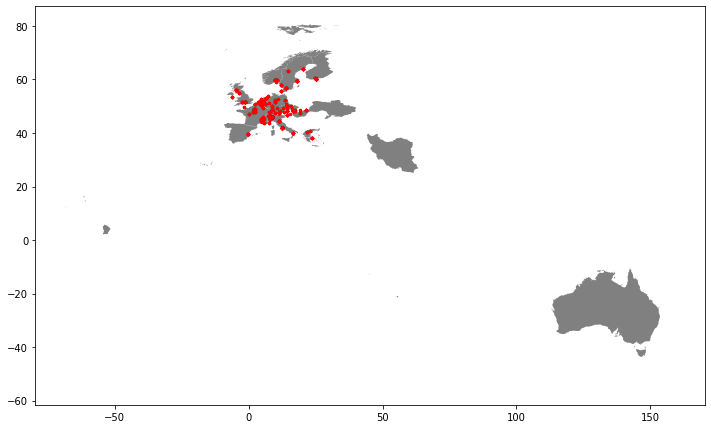

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 5, color = 'r', alpha = 0.5)

Now, our plot shows all data points falling in continental Europe. 

## Australia

Looking at the plot above, we can tell that certain countries should probably not be present in the map. Australia, for example, has no data points mapped to it. Iran, likewise, is just sitting there. 

We will start with Australia. On the surface, it looks like our Chernobyl data contains Australia. 

In [40]:
'AU' in gdf_air.country_code.values

True

If we look at the data for AU in the air data, we'll find out what the issue is. 

In [41]:
gdf_air.loc[gdf_air.country_code == 'AU']

Unnamed: 0 country_code  Code     city  latitude  longitude        Date  \
1321        1321           AU    14  BREGENZ      9.78      47.51  1986-04-30   
1322        1322           AU    14  BREGENZ      9.78      47.51  1986-05-01   
1323        1323           AU    14  BREGENZ      9.78      47.51  1986-05-02   
1324        1324           AU    14  BREGENZ      9.78      47.51  1986-05-03   
1325        1325           AU    14  BREGENZ      9.78      47.51  1986-05-04   
...          ...          ...   ...      ...       ...        ...         ...   
1539        1539           AU    14  VIENNA.     16.36      48.21  1986-05-14   
1540        1540           AU    14  VIENNA.     16.36      48.21  1986-05-14   
1541        1541           AU    14  VIENNA.     16.36      48.21  1986-05-15   
1542        1542           AU    14  VIENNA.     16.36      48.21  1986-05-15   
1543        1543           AU    14  VIENNA.     16.36      48.21  1986-05-16   

      endsampling  duration      i131    cs134     cs137  \
1321            6     23.00  0.008510      NaN  0.001139   
1322            7     24.54  2.401300  0.40293  0.592000   
1323            7     24.20  4.884000  1.83150  3.367000   
1324            7     23.43  2.978500  1.16402  2.220000   
1325            7     23.59  1.180300  0.32153  0.621600   
...           ...       ...       ...      ...       ...   
1539            8     12.00  0.018500      NaN       NaN   
1540           19     11.17  0.028860      NaN       NaN   
1541            7     11.20  0.008510      NaN       NaN   
1542           19     11.52  0.017575      NaN       NaN   
1543           19     23.53  0.006623      NaN       NaN   

                       geometry  
1321   POINT (9.78000 47.51000)  
1322   POINT (9.78000 47.51000)  
1323   POINT (9.78000 47.51000)  
1324   POINT (9.78000 47.51000)  
1325   POINT (9.78000 47.51000)  
...                         ...  
1539  POINT (16.36000 48.21000)  
1540  POINT (16.36000 48.21000)  
1541  POINT (16.36000 48.21000)  
1542  POINT (16.36000 48.21000)  
1543  POINT (16.36000 48.21000)  

[223 rows x 13 columns]

Here's the issue: the country code here suggests its Australia, but in reality this is Austria (Vienna gave it away). In modern two letter code, this should be AT. Let's make the switch.  

In [42]:
gdf_air.loc[gdf_air.country_code == 'AU', 'country_code'] = 'AT'

Now, we need to remove the Australia from map data and add in Austria. 

In [43]:
uf.change_au(gdf_europe, gdf_world)

Now our plot should not have Australia in it. 

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 2, color = 'r', alpha = 0.5)

## Iran

Continuing our plot desctrution scheme, notice Iran's shape on the far right side. Did our Chernobyl data really have data from Iran?

In [45]:
gdf_air.loc[gdf_air.country_code == 'IR'].head()

Unnamed: 0 country_code  Code              city  latitude  longitude  \
537         537           IR     4  GLASNEVIN.Dublin     -6.28      53.37   
538         538           IR     4  GLASNEVIN.Dublin     -6.28      53.37   
539         539           IR     4  GLASNEVIN.Dublin     -6.28      53.37   
540         540           IR     4  GLASNEVIN.Dublin     -6.28      53.37   
541         541           IR     4  GLASNEVIN.Dublin     -6.28      53.37   

           Date  endsampling  duration  i131    cs134  cs137  \
537  1986-05-01           10      24.0   0.0  0.00000    NaN   
538  1986-05-02           10      24.0   0.0  0.00000    NaN   
539  1986-05-03           10      24.0   0.0  0.02104    NaN   
540  1986-05-04           10      24.0   0.0  0.00781    NaN   
541  1986-05-05           10      24.0   0.0  0.00000    NaN   

                      geometry  
537  POINT (-6.28000 53.37000)  
538  POINT (-6.28000 53.37000)  
539  POINT (-6.28000 53.37000)  
540  POINT (-6.28000 53.37000)  
541  POINT (-6.28000 53.37000)

The data set did not have data frome Iran. By current standards, Ireland's country code is actually IE, not IR. Like we did for Australia, we'll remove Iran. But first, we change IR to IE in the original data. 

In [46]:
gdf_air.loc[gdf_air.country_code == 'IR', 'country_code'] = 'IE'

Now we replace Iran with Ireland in the map data.

In [47]:
gdf_europe = uf.change_ir(gdf_europe, gdf_world)

We can now view the map without Iran, but with Ireland included. 

In [48]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 2, color = 'r', alpha = 0.5)

## Zooming in 
At this point, most of our data is plotted on countries from continental Europe. Certain territories are pushing the map making it hard to see how the data plots on the map. Instead of removing territories from contries, we will simply change the axis bounds on our plot. 

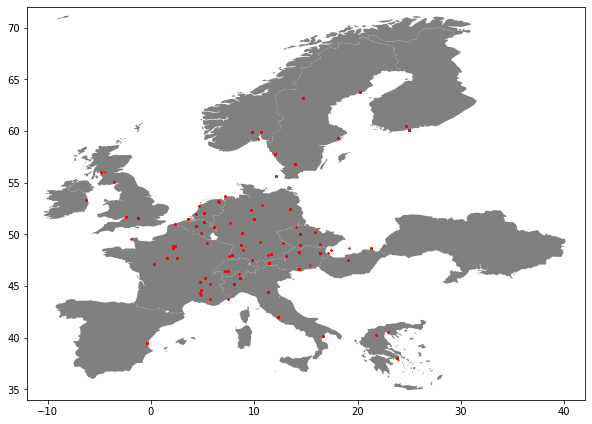

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

xlim = ([-12,  42])
ylim = ([34,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 1, color = 'r', alpha = 0.5)

## Final points 
You'll note that three points (to the left of Ukraine) seem to be missing their country. This is Slovakia. This could be due to the fact that in 1986 Slovakia was still a part of the Czhech Repbulic (Czechoslovakia). We will confirm this in our original Chernobyl data by looking at lats and longs for its cities. 

The way to do this is by using bounding boxes. We acquire coordinates for each city already present in the data, and see if they fall within now Slovakia from the original gdf map. Then, we change the country code for these measurements to be Slovakia's.

In [50]:
gdf_air = uf.change_slovakia(gdf_air, gdf_world)

Now add in Slovakia to our Europe map. 

In [51]:
gdf_europe = uf.add_slovakia(gdf_europe, gdf_world)

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))

xlim = ([-12,  42])
ylim = ([34,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 2, color = 'r', alpha = 0.5)

This is awesome. We now have Slovakia holding its points. 

## Luxembourg

You'll notice a small empty space between France and Germany. This is Luxembourg, and we simply didn't include it originally since no air data has measures from Luxembourg. However, it would make the map look more continuous so we will include it. 

In [53]:
gdf_europe = uf.include_lux(gdf_europe, gdf_world)

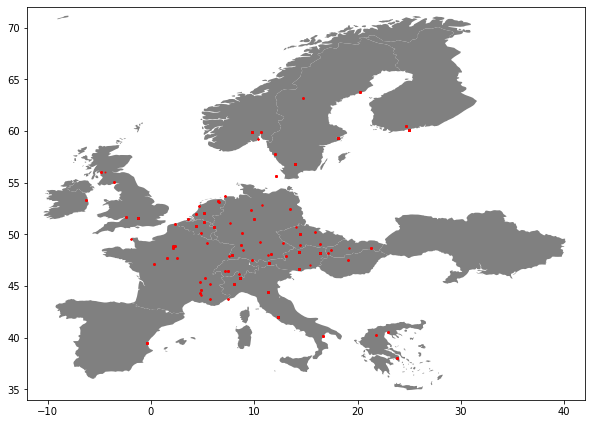

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))

xlim = ([-12,  42])
ylim = ([34,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_europe.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 1, color = 'r', alpha = 0.5)

Here, we will write out the europe map we are using, and our Chernobyl air data since we have substantially changed it. 

In [55]:
gdf_air.to_csv('air_modified.csv')

In [56]:
gdf_europe.to_file('europe_map.shp')

## Alternatives

An alternative way to map, is to simply plot the data on the world map using similar axes limits. At this point, we have modified the original data to fall on the right countries. Thus, by plotting right on the world map we might get a more complete view of continental Europe. 

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

xlim = ([-12,  42])
ylim = ([34,  72])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

gdf_world.plot(ax = ax, color = 'gray')
gdf_air.plot(ax = ax, markersize = 1, color = 'r', alpha = 0.5)

This looks like a better plot so we will use it instead of the just the European countries. 